# RSNA Pediatric Bone Age Estimation

This notebook implements a deep-learning pipeline to predict bone age from hand radiographs using the RSNA Bone Age dataset. First, I mounted Google Drive and installed the required dependencies (including `kagglehub`), then loaded the training and testing CSV files and mapped each record to its corresponding image path.

After loading the data, data analysis was performed. I computed summary statistics for the bone age values—observing a range from newborns up to 228 months with a slight right skew—and visualized this distribution using histograms and kernel density plots.

Next, I examined the patient sex distribution, finding an approximately balanced male/female split, and generated separate age-by-sex boxplots to highlight any subgroup differences or outliers. I also checked for missing values ,and applied label encoding to convert the `Sex` column into a binary feature, and normalized bone age into a consistent scale for regression.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# # These lines of code are only needed when uploading a file
# from google.colab import files
# files.upload()

In [4]:
!pip install --quiet kagglehub
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/    # place your token
!chmod 600 ~/.kaggle/kaggle.json not for all run
!pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

#File path to where the dataset is imported
file_path = "boneage-training-dataset.csv"  # This dataset contains 'boneage-training-dataset.csv'

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "kmader/rsna-bone-age",
  file_path
)


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access 'not': No such file or directory
chmod: cannot access 'for': No such file or directory
chmod: cannot access 'all': No such file or directory
chmod: cannot access 'run': No such file or directory


<ipython-input-4-7e7ddad43ec2>:13: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [5]:

#Import all the required functions and library
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Concatenate



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Dataset
I loaded a total of 12,611 labeled hand radiographs for training (and its held-out 3,000-image validation split) plus 200 unlabeled test images, and fed them into TensorFlow’s `tf.data` pipeline at a batch size of 32—yielding 316 training batches, 79 validation batches, and 7 test batches.
 I then examined the overall bone-age distribution, plotting both month-based and year-based histograms (with KDE overlays).
 I computed summary statistics (count, mean, std, min, quartiles, and max) on both the raw `boneage` and its normalized “age\_years” equivalent, applied label encoding to transform `Sex` into a binary feature and also performed data augmentation.

In [6]:
# Output directory for saved models
OUTPUT_DIR = Path("/content/drive/MyDrive/rsna_boneage_models")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [7]:
# paths
train_dir = Path("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset")
test_dir  = Path("/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset")


In [8]:
# Load CSVs
train_df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "kmader/rsna-bone-age",
                                  "boneage-training-dataset.csv")
test_df  = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "kmader/rsna-bone-age",
                                  "boneage-test-dataset.csv")

# Add the image file path column (for both train & test)
train_df['filepath'] = train_df['id'].astype(str).apply(lambda x: train_dir / f"{x}.png")
test_df [ 'filepath'] = test_df['Case ID'].astype(str).apply(lambda x: test_dir  / f"{x}.png")

# Split off 20% for validation (stratified by sex)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['male']
)

# Ensure all filepaths are plain strings (not Path objects)
train_df['filepath'] = train_df['filepath'].astype(str)
val_df  ['filepath'] = val_df  ['filepath'].astype(str)
test_df ['filepath'] = test_df ['filepath'].astype(str)

# Normalize the target column
max_age = train_df['boneage'].max()
train_df['boneage_norm'] = train_df['boneage'] / max_age
val_df  ['boneage_norm'] = val_df  ['boneage'] / max_age


In [10]:
# Show the first 5 rows of the training DataFrame
print("training data")
display(train_df.head())

# Show the first 5 rows of the testing DataFrame
print("testing data")
display(test_df.head())


training data


,id,boneage,male,filepath,boneage_norm
7612,10013,120,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.526316
608,2062,84,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.368421
12056,14995,150,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.657895
11184,14023,108,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.473684
9252,11862,174,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.763158


testing data


,Case ID,Sex,filepath
0,4360,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
1,4361,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
2,4362,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
3,4363,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
4,4364,M,/kaggle/input/rsna-bone-age/boneage-test-datas...


In [11]:
# Display 5 random rows from the train DataFrame
print("Random Training dataset")
display(train_df.sample(5,random_state=42))

# Display 5 random rows from the test DataFrame
print("Random Testing dataset")
display(test_df.sample(5,random_state=42))


Random Training dataset


,id,boneage,male,filepath,boneage_norm
9905,12587,162,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.710526
3694,5668,132,False,/kaggle/input/rsna-bone-age/boneage-training-d...,0.578947
8744,11287,156,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.684211
3874,5870,106,False,/kaggle/input/rsna-bone-age/boneage-training-d...,0.464912
600,2053,132,True,/kaggle/input/rsna-bone-age/boneage-training-d...,0.578947


Random Testing dataset


,Case ID,Sex,filepath
95,4455,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
15,4375,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
30,4390,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
158,4518,F,/kaggle/input/rsna-bone-age/boneage-test-datas...
128,4488,F,/kaggle/input/rsna-bone-age/boneage-test-datas...


In [12]:
# Structural summary of training dataset
print("training data info")
display(train_df.info())

# structural summary of the testing dataset
print("testing data info")
display(test_df.info() )

training data info
<class 'pandas.core.frame.DataFrame'>
Index: 10088 entries, 7612 to 11574
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10088 non-null  int64  
 1   boneage       10088 non-null  int64  
 2   male          10088 non-null  bool   
 3   filepath      10088 non-null  object 
 4   boneage_norm  10088 non-null  float64
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 403.9+ KB


None

testing data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Case ID   200 non-null    int64 
 1   Sex       200 non-null    object
 2   filepath  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


None

In [13]:
# summary statistics for all numeric columns
print("Age distribution")
train_df['age_years']=(train_df['boneage']/12).round(8)
display(train_df.describe())

Age distribution


,id,boneage,boneage_norm,age_years
count,10088.000000,10088.000000,10088.000000,10088.000000
mean,8504.406324,127.297780,0.558324,10.608148
std,4102.447829,41.051244,0.180049,3.420937
min,1377.000000,1.000000,0.004386,0.083333
25%,5044.500000,96.000000,0.421053,8.000000
50%,8530.500000,132.000000,0.578947,11.000000
75%,12047.250000,156.000000,0.684211,13.000000
max,15608.000000,228.000000,1.000000,19.000000


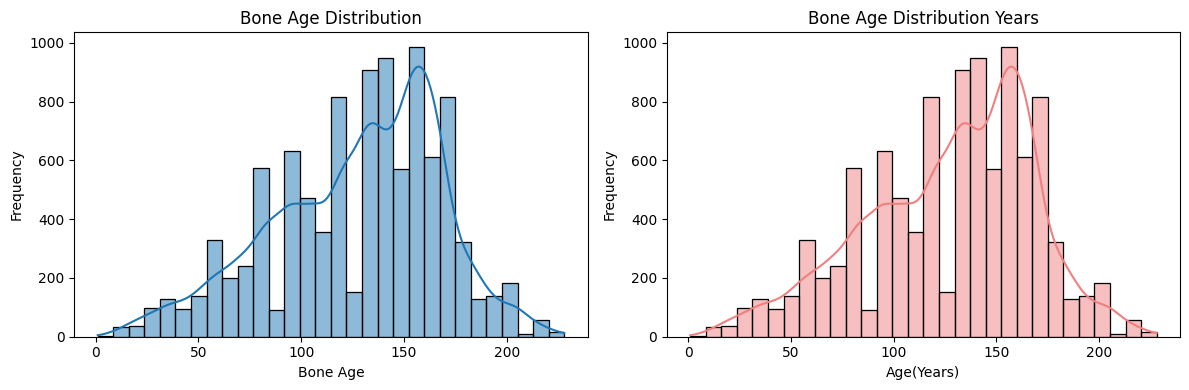

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#Bone age distribution in months
sns.histplot(train_df['boneage'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Bone Age Distribution')
axes[0].set_xlabel('Bone Age')
axes[0].set_ylabel('Frequency')

#Bone age distribution in years
sns.histplot(train_df['boneage'], bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Bone Age Distribution Years')
axes[1].set_xlabel('Age(Years)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-16-1024c5ede3bd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='male', data=train_df, palette=['lightpink', 'lightblue'])


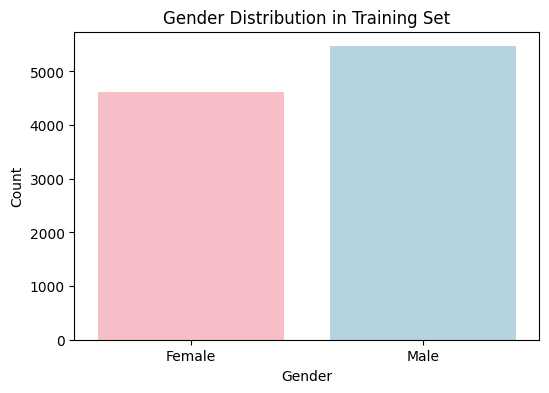

In [16]:
# Gender Distribution in Training Set
plt.figure(figsize=(6, 4))
sns.countplot(x='male', data=train_df, palette=['lightpink', 'lightblue'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution in Training Set')
plt.xticks(ticks=[0, 1], labels=["Female", "Male"])
plt.show()

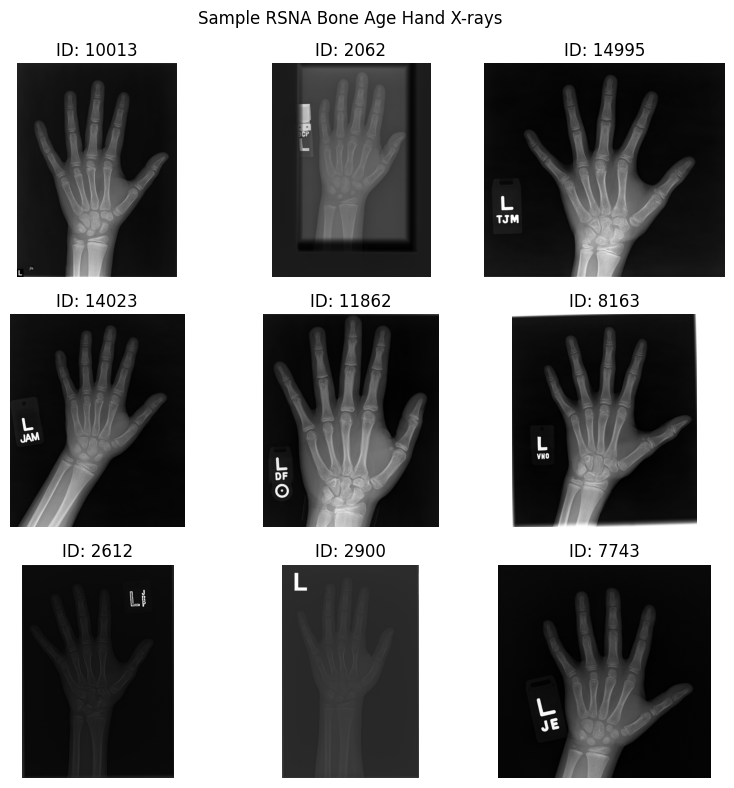

In [18]:
# Display the first 9 images in a 3×3 grid
plt.figure(figsize=(8,8))
for i, img_path in enumerate(train_df['filepath'][:9]):
    plt.subplot(3,3,i+1)
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"ID: {train_df.iloc[i]['id']}")
    plt.axis('off')
plt.suptitle("Sample RSNA Bone Age Hand X-rays")
plt.tight_layout()
plt.show()

In [19]:
img_size   = (300, 300)
batch_size = 32

In [21]:
# define the parser
def parse_single(filepath, age):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = effnet_preprocess(img)
    age = tf.cast(age, tf.float32)
    return img, tf.expand_dims(age, -1)

# Now build ds_train
ds_train = tf.data.Dataset.from_tensor_slices((
    train_df['filepath'].values,
    train_df['boneage_norm'].values
))
ds_train = (
    ds_train
    .map(parse_single, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1024, seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# build ds_val
ds_val = tf.data.Dataset.from_tensor_slices((
    val_df['filepath'].values,
    val_df['boneage_norm'].values
))
ds_val = (
    ds_val
    .map(parse_single, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# build ds_test
ds_test = tf.data.Dataset.from_tensor_slices(test_df['filepath'].values)
ds_test = (
    ds_test
    .map(lambda fp: tf.image.resize(
             effnet_preprocess(
               tf.image.decode_png(tf.io.read_file(fp), channels=3)
             ),
             img_size
           ),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"DS train batches: {ds_train.cardinality().numpy()} batches of {batch_size}")
print(f"DS val   batches: {ds_val.cardinality().numpy()} batches of {batch_size}")
print(f"DS test  batches: {ds_test.cardinality().numpy()} batches of {batch_size}")



DS train batches: 316 batches of 32
DS val   batches: 79 batches of 32
DS test  batches: 7 batches of 32


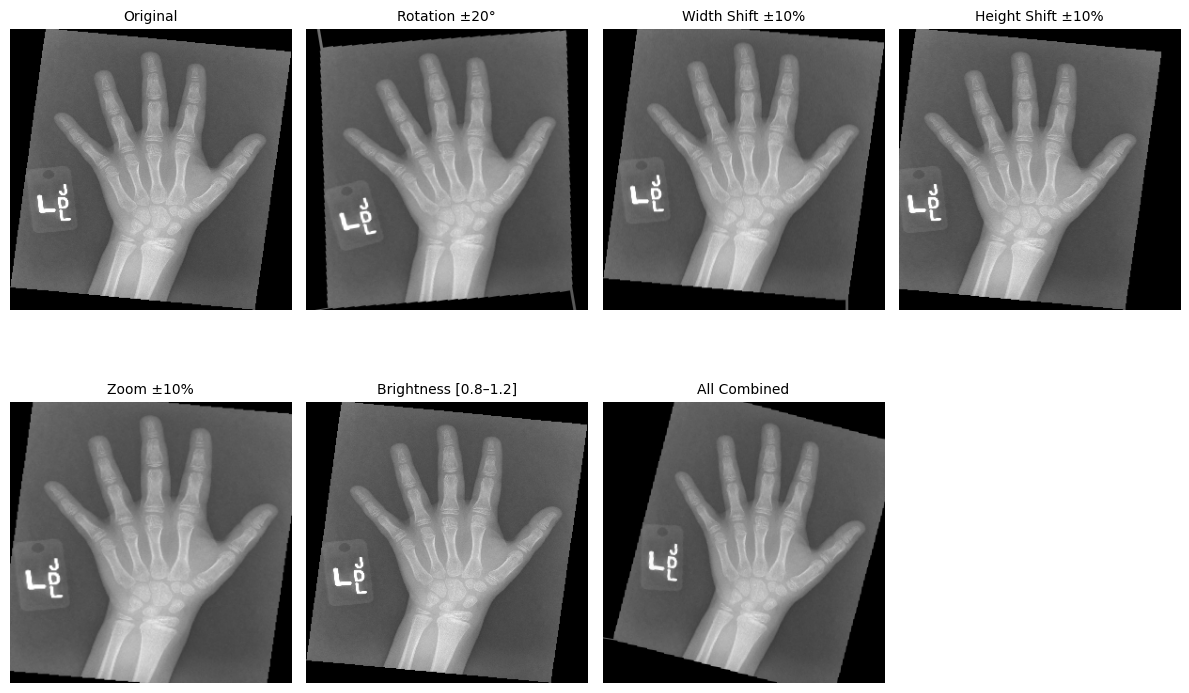

In [22]:
# Load one image from the validation set
img_path   = val_df['filepath'].iloc[0]
img        = load_img(img_path, target_size=img_size)
img_array  = img_to_array(img)                  # shape=(224,224,3), values [0–255]
img_array  = np.expand_dims(img_array, axis=0)  # shape=(1,224,224,3)

# Define augmentations
augmentations = {
    "Original":         ImageDataGenerator(preprocessing_function=effnet_preprocess),
    "Rotation ±20°":    ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                           rotation_range=20),
    "Width Shift ±10%": ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                           width_shift_range=0.1),
    "Height Shift ±10%":ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                           height_shift_range=0.1),
    "Zoom ±10%":        ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                           zoom_range=0.1),
    "Brightness [0.8–1.2]": ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                               brightness_range=[0.8,1.2]),
    "All Combined":     ImageDataGenerator(preprocessing_function=effnet_preprocess,
                                           rotation_range=20,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           zoom_range=0.1,
                                           brightness_range=[0.8,1.2],
                                           fill_mode='nearest'),
}

# Plot each augmented version
plt.figure(figsize=(12, 8))
for i, (name, gen) in enumerate(augmentations.items()):
    aug_iter = gen.flow(img_array, batch_size=1)
    aug_img  = next(aug_iter)[0].astype(np.uint8)

    plt.subplot(2, 4, i+1)
    plt.imshow(aug_img)
    plt.title(name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()




### Models
Both of the architectures build are on an ImageNet-pretrained EfficientNet-B3 backbone, but differ in how they fuse auxiliary information for bone-age regression. The **baseline model **simply strips off EfficientNet’s classifier head, applies global average pooling to the final feature maps, and then passes them through a 256-unit ReLU + dropout block before a single linear neuron that predicts normalized bone age.

 In contrast, the **multi-input model** takes those same visual features, concatenates them with a one-dimensional sex indicator (0 or 1), and then routes the combined vector through the same 256-unit ReLU + dropout block into its final regression output—allowing the network to learn gender-specific growth patterns alongside purely radiographic cues.

To see how each prediction are made , I generate **Grad-CAM heatmaps** by computing the gradient of the bone-age output with respect to the last convolutional feature maps.
After globally averaging these gradients, I weight and sum the feature maps to produce a coarse localization map, then overlay it in transparent red over the original X-ray.
These heatmaps consistently highlight the growth plates and carpals—regions that human readers also focus on—providing confidence that the model is attending to medically relevant anatomy rather than spurious artifacts.


In [26]:
# baseline model
def build_baseline_model(input_shape=(300,300,3), dropout=0.5):
    base = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape

    )
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    out = Dense(1, activation='linear')(x)   # predicts normalized boneage

    model = Model(inputs=base.input, outputs=out, name="EffNetB3_baseline")
    model.compile(
        optimizer=Adam(1e-4),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

model = build_baseline_model()
model.summary()


Model: "EffNetB3_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 11,089,961 (42.30 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [27]:
# Set up callbacks and early stopping

checkpoint = ModelCheckpoint(
    filepath="best_baseline_{epoch:02d}-{val_mean_absolute_error:.3f}.h5",
    monitor="val_mean_absolute_error",
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [28]:
# training
lr_scheduler = ReduceLROnPlateau(
    monitor='val_mean_absolute_error',
    factor=0.5,       # cut LR in half
    patience=5,       # wait 5 epochs without improvement
    min_lr=1e-6,      #o
    verbose=1
)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    verbose=2
)

Epoch 1/50

Epoch 1: val_mean_absolute_error improved from inf to 0.10804, saving model to best_baseline_01-0.108.h5


316/316 - 349s - 1s/step - loss: 0.1854 - mean_absolute_error: 0.1854 - mean_squared_error: 0.0642 - val_loss: 0.1080 - val_mean_absolute_error: 0.1080 - val_mean_squared_error: 0.0181 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_mean_absolute_error improved from 0.10804 to 0.06633, saving model to best_baseline_02-0.066.h5


316/316 - 33s - 104ms/step - loss: 0.1112 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0198 - val_loss: 0.0663 - val_mean_absolute_error: 0.0663 - val_mean_squared_error: 0.0072 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_mean_absolute_error improved from 0.06633 to 0.06580, saving model to best_baseline_03-0.066.h5


316/316 - 33s - 104ms/step - loss: 0.0968 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0150 - val_loss: 0.0658 - val_mean_absolute_error: 0.0658 - val_mean_squared_error: 0.0070 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_mean_absolute_error improved from 0.06580 to 0.05920, saving model to best_baseline_04-0.059.h5


316/316 - 33s - 106ms/step - loss: 0.0930 - mean_absolute_error: 0.0930 - mean_squared_error: 0.0137 - val_loss: 0.0592 - val_mean_absolute_error: 0.0592 - val_mean_squared_error: 0.0056 - learning_rate: 1.0000e-04
Epoch 5/50

Epoch 5: val_mean_absolute_error improved from 0.05920 to 0.05741, saving model to best_baseline_05-0.057.h5


316/316 - 33s - 104ms/step - loss: 0.0876 - mean_absolute_error: 0.0876 - mean_squared_error: 0.0122 - val_loss: 0.0574 - val_mean_absolute_error: 0.0574 - val_mean_squared_error: 0.0053 - learning_rate: 1.0000e-04
Epoch 6/50

Epoch 6: val_mean_absolute_error improved from 0.05741 to 0.05148, saving model to best_baseline_06-0.051.h5


316/316 - 33s - 104ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - mean_squared_error: 0.0114 - val_loss: 0.0515 - val_mean_absolute_error: 0.0515 - val_mean_squared_error: 0.0044 - learning_rate: 1.0000e-04
Epoch 7/50

Epoch 7: val_mean_absolute_error did not improve from 0.05148
316/316 - 31s - 99ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - mean_squared_error: 0.0104 - val_loss: 0.0558 - val_mean_absolute_error: 0.0558 - val_mean_squared_error: 0.0049 - learning_rate: 1.0000e-04
Epoch 8/50

Epoch 8: val_mean_absolute_error improved from 0.05148 to 0.05035, saving model to best_baseline_08-0.050.h5


316/316 - 33s - 103ms/step - loss: 0.0776 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0097 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503 - val_mean_squared_error: 0.0041 - learning_rate: 1.0000e-04
Epoch 9/50

Epoch 9: val_mean_absolute_error improved from 0.05035 to 0.04896, saving model to best_baseline_09-0.049.h5


316/316 - 33s - 104ms/step - loss: 0.0760 - mean_absolute_error: 0.0760 - mean_squared_error: 0.0093 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490 - val_mean_squared_error: 0.0040 - learning_rate: 1.0000e-04
Epoch 10/50

Epoch 10: val_mean_absolute_error did not improve from 0.04896
316/316 - 31s - 100ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - mean_squared_error: 0.0084 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510 - val_mean_squared_error: 0.0043 - learning_rate: 1.0000e-04
Epoch 11/50

Epoch 11: val_mean_absolute_error did not improve from 0.04896
316/316 - 31s - 99ms/step - loss: 0.0727 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0084 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538 - val_mean_squared_error: 0.0046 - learning_rate: 1.0000e-04
Epoch 12/50

Epoch 12: val_mean_absolute_error improved from 0.04896 to 0.04841, saving model to best_baseline_12-0.048.h5


316/316 - 33s - 104ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0079 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484 - val_mean_squared_error: 0.0038 - learning_rate: 1.0000e-04
Epoch 13/50

Epoch 13: val_mean_absolute_error improved from 0.04841 to 0.04472, saving model to best_baseline_13-0.045.h5


316/316 - 33s - 104ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0074 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447 - val_mean_squared_error: 0.0033 - learning_rate: 1.0000e-04
Epoch 14/50

Epoch 14: val_mean_absolute_error did not improve from 0.04472
316/316 - 31s - 100ms/step - loss: 0.0662 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0071 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461 - val_mean_squared_error: 0.0035 - learning_rate: 1.0000e-04
Epoch 15/50

Epoch 15: val_mean_absolute_error did not improve from 0.04472
316/316 - 31s - 99ms/step - loss: 0.0644 - mean_absolute_error: 0.0644 - mean_squared_error: 0.0068 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452 - val_mean_squared_error: 0.0035 - learning_rate: 1.0000e-04
Epoch 16/50

Epoch 16: val_mean_absolute_error did not improve from 0.04472
316/316 - 31s - 99ms/step - loss: 0.0624 - mean_absolute_error: 0.0624 - mean_squared_error: 0.0064 - val_loss: 0.0497 - val_mea

In [29]:
model.save(OUTPUT_DIR / "baseline_final.h5")
print("Saved final model to", OUTPUT_DIR / "baseline_final.h5")

Saved final model to /content/drive/MyDrive/rsna_boneage_models/baseline_final.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


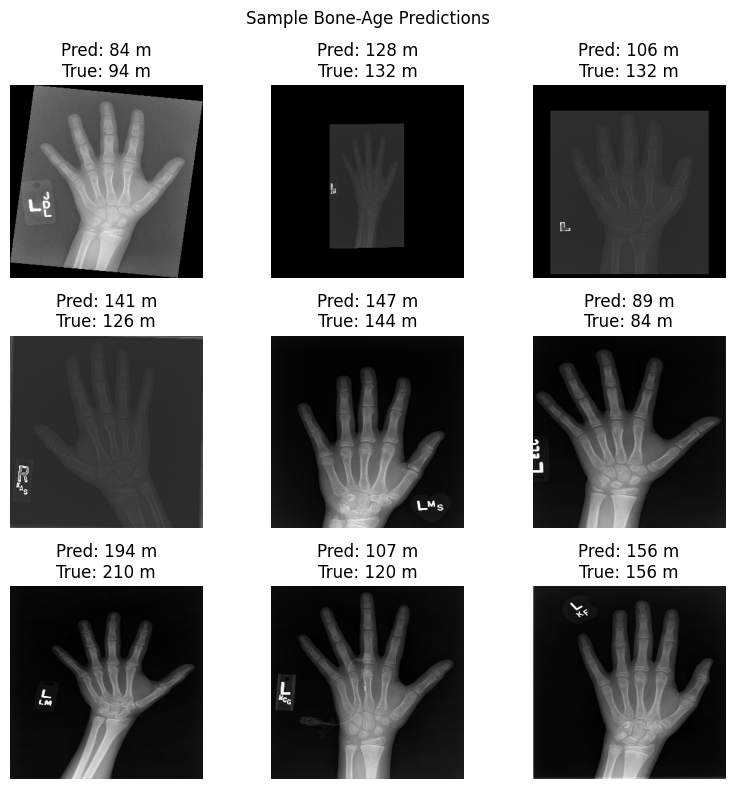

In [31]:
batch = next(iter(ds_val))
imgs, age_norm = batch

# Denormalize true ages and get predictions
max_age = train_df['boneage'].max()
y_true_month = age_norm.numpy().flatten() * max_age
y_pred_month = model.predict(imgs).flatten() * max_age

# Plot a 3×3 grid of sample predictions
import matplotlib.pyplot as plt

n = min(len(imgs), 9)
plt.figure(figsize=(8,8))
for i in range(n):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].numpy().astype('uint8'))
    plt.title(f"Pred: {y_pred_month[i]:.0f} m\nTrue: {y_true_month[i]:.0f} m")
    plt.axis('off')
plt.suptitle("Sample Bone-Age Predictions")
plt.tight_layout()
plt.show()



In [32]:
# Evaluate and dict of all metrics
results = model.evaluate(ds_val, verbose=1, return_dict=True)

val_mae = results['mean_absolute_error']     # normalized units
val_mse = results['mean_squared_error']      # normalized units

print(f"Validation MAE: {val_mae*100:.1f} months")
print(f"Validation MSE: {val_mse*10000:.3f} (months²)")


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - mean_squared_error: 0.0033
Validation MAE: 4.5 months
Validation MSE: 33.432 (months²)


In [35]:
# Run inference on the tf.data.Dataset,
y_test_norm = model.predict(ds_test, verbose=1).flatten()

# De-normalize back to actual months using the same max_age
y_test_pred = y_test_norm * max_age

# Attach predictions to your test_df
test_df['boneage_pred'] = y_test_pred

# Display the first 10 predictions
display(test_df[['Case ID', 'boneage_pred']].head(10))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


,Case ID,boneage_pred
0,4360,175.819061
1,4361,161.916000
2,4362,67.762039
3,4363,158.440643
4,4364,128.013382
5,4365,49.154739
6,4366,157.763168
7,4367,143.103455
8,4368,172.793579
9,4369,188.112915


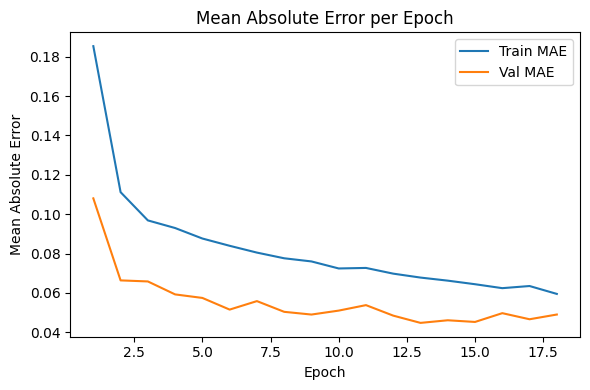

In [36]:
# MAE per epoch
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history.history['mean_absolute_error'],     label='Train MAE')
plt.plot(epochs, history.history['val_mean_absolute_error'], label='Val MAE')
plt.title('Mean Absolute Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()

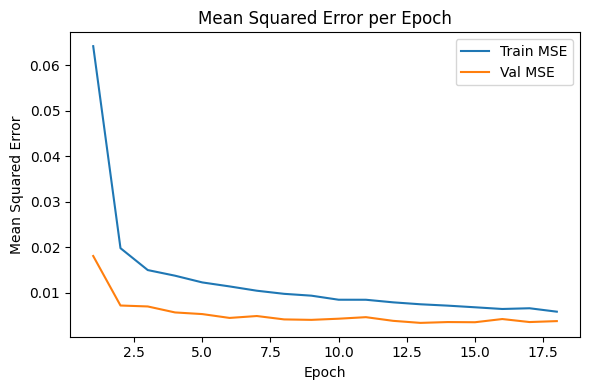

In [38]:
#MSE per epoch
plt.figure(figsize=(6, 4))
plt.plot(epochs, history.history['mean_squared_error'],     label='Train MSE')
plt.plot(epochs, history.history['val_mean_squared_error'], label='Val MSE')
plt.title('Mean Squared Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# predictions on  validation set
y_norm_pred = model.predict(ds_val, verbose=1).flatten()

# Denormalize back to months
y_pred = y_norm_pred * 100.0

# True ages (in months)
y_true = val_df['boneage_norm'].values * 100.0

# Compute metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
acc6  = np.mean(np.abs(y_pred - y_true) <= 6.0) * 100  # % within ±6 months
acc12 = np.mean(np.abs(y_pred - y_true) <= 12.0) * 100 # % within ±12 months

# Print summary
print(f"MAE:   {mae:.2f} months")
print(f"RMSE:  {rmse:.2f} months")
print(f"MSE:   {mse:.2f}")
print(f"R²:    {r2:.3f}")
print(f"% within ±6 mo:  {acc6:.1f}%")
print(f"% within ±12 mo: {acc12:.1f}%")


79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step
MAE:   4.47 months
RMSE:  5.78 months
MSE:   33.43
R²:    0.900
% within ±6 mo:  71.9%
% within ±12 mo: 96.0%


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


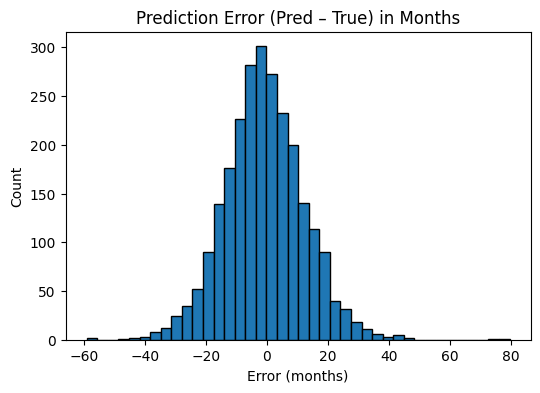

In [42]:
# Get predictions (normalized)
y_pred_norm = model.predict(ds_val).flatten()

# Extract the true normalized ages
y_true_norm = np.concatenate([
    y.numpy().flatten()
    for _, y in ds_val
], axis=0)

#  De‐normalize back to months (use the same max_age you used above)
y_pred_months = y_pred_norm * max_age
y_true_months = y_true_norm * max_age

# Compute errors in months
errors = y_pred_months - y_true_months

# Plot their histogram
plt.figure(figsize=(6,4))
plt.hist(errors, bins=40, edgecolor='black')
plt.title('Prediction Error (Pred – True) in Months')
plt.xlabel('Error (months)')
plt.ylabel('Count')
plt.show()

In [43]:
# Parse function for multi-input
def parse_multi(filepath, sex, age):
    # Load & preprocess image
    img = tf.io.read_file(filepath)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = effnet_preprocess(img)

    # Cast numeric inputs
    sex = tf.cast(sex, tf.float32)
    age = tf.cast(age, tf.float32)

    return (
        {'image_input': img, 'sex_input': tf.expand_dims(sex, -1)},
        tf.expand_dims(age, -1)
    )

In [44]:
for df in (train_df, val_df):
    df['sex_norm'] = df['male'].astype('float32')
# Build tf.data datasets
ds_train = tf.data.Dataset.from_tensor_slices((
    train_df['filepath'].values,
    train_df['sex_norm'].values,
    train_df['boneage_norm'].values
))
ds_train = (
    ds_train
      .map(parse_multi, num_parallel_calls=tf.data.AUTOTUNE)
      .cache()
      .shuffle(1024, seed=42)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

ds_val = tf.data.Dataset.from_tensor_slices((
    val_df['filepath'].values,
    val_df['sex_norm'].values,
    val_df['boneage_norm'].values
))
ds_val = (
    ds_val
      .map(parse_multi, num_parallel_calls=tf.data.AUTOTUNE)
      .cache()
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)


In [45]:
# Build & compile the multi-input model
def build_multi_input_model(dropout=0.5):
    img_input = Input(shape=(*img_size,3), name='image_input')
    sex_input = Input(shape=(1,),      name='sex_input')

    x = EfficientNetB3(weights='imagenet', include_top=False)(img_input)
    feat = GlobalAveragePooling2D()(x)

    x = Concatenate()([feat, sex_input])
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    out = Dense(1, activation='linear', name='boneage_output')(x)

    m = Model([img_input, sex_input], out, name='multi_input')
    m.compile(
        optimizer=Adam(1e-4),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    return m

model = build_multi_input_model()
model.summary()

Model: "multi_input"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 9, 9,      │ 10,783,535 │ image_input[0][0] │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1537)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ sex_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    393,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boneage_output      │ (None, 1)         │        257 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,177,520 (42.64 MB)

 Trainable params: 11,090,217 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [46]:
# Callbacks & training
checkpoint = ModelCheckpoint(
    OUTPUT_DIR / "best_multi_input_{epoch:02d}-{val_mean_absolute_error:.3f}.h5",
    monitor="val_mean_absolute_error",
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=5,
    restore_best_weights=True,
    verbose=1
)



In [47]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_mean_absolute_error',
    factor=0.5,        # cut LR in half when plateauing
    patience=5,        # wait 5 epochs without improvement
    min_lr=1e-6,       # never go below this LR
    verbose=1
)
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=40,
    callbacks=[early_stop, checkpoint],
    verbose=2
)


Epoch 1/40

Epoch 1: val_mean_absolute_error improved from inf to 0.08859, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_01-0.089.h5


316/316 - 291s - 922ms/step - loss: 0.1835 - mean_absolute_error: 0.1835 - val_loss: 0.0886 - val_mean_absolute_error: 0.0886
Epoch 2/40

Epoch 2: val_mean_absolute_error improved from 0.08859 to 0.05926, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_02-0.059.h5


316/316 - 32s - 100ms/step - loss: 0.1060 - mean_absolute_error: 0.1060 - val_loss: 0.0593 - val_mean_absolute_error: 0.0593
Epoch 3/40

Epoch 3: val_mean_absolute_error improved from 0.05926 to 0.05449, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_03-0.054.h5


316/316 - 32s - 100ms/step - loss: 0.0906 - mean_absolute_error: 0.0906 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epoch 4/40

Epoch 4: val_mean_absolute_error improved from 0.05449 to 0.04794, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_04-0.048.h5


316/316 - 32s - 100ms/step - loss: 0.0845 - mean_absolute_error: 0.0845 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479
Epoch 5/40

Epoch 5: val_mean_absolute_error improved from 0.04794 to 0.04651, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_05-0.047.h5


316/316 - 31s - 100ms/step - loss: 0.0794 - mean_absolute_error: 0.0794 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 6/40

Epoch 6: val_mean_absolute_error improved from 0.04651 to 0.04335, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_06-0.043.h5


316/316 - 31s - 100ms/step - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434
Epoch 7/40

Epoch 7: val_mean_absolute_error improved from 0.04335 to 0.04216, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_07-0.042.h5


316/316 - 32s - 100ms/step - loss: 0.0739 - mean_absolute_error: 0.0739 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 8/40

Epoch 8: val_mean_absolute_error did not improve from 0.04216
316/316 - 30s - 95ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - val_loss: 0.0497 - val_mean_absolute_error: 0.0497
Epoch 9/40

Epoch 9: val_mean_absolute_error did not improve from 0.04216
316/316 - 30s - 95ms/step - loss: 0.0687 - mean_absolute_error: 0.0687 - val_loss: 0.0472 - val_mean_absolute_error: 0.0472
Epoch 10/40

Epoch 10: val_mean_absolute_error improved from 0.04216 to 0.03818, saving model to /content/drive/MyDrive/rsna_boneage_models/best_multi_input_10-0.038.h5


316/316 - 32s - 101ms/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382
Epoch 11/40

Epoch 11: val_mean_absolute_error did not improve from 0.03818
316/316 - 30s - 96ms/step - loss: 0.0648 - mean_absolute_error: 0.0648 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 12/40

Epoch 12: val_mean_absolute_error did not improve from 0.03818
316/316 - 30s - 96ms/step - loss: 0.0635 - mean_absolute_error: 0.0635 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 13/40

Epoch 13: val_mean_absolute_error did not improve from 0.03818
316/316 - 30s - 96ms/step - loss: 0.0625 - mean_absolute_error: 0.0625 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401
Epoch 14/40

Epoch 14: val_mean_absolute_error did not improve from 0.03818
316/316 - 31s - 97ms/step - loss: 0.0603 - mean_absolute_error: 0.0603 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 15/40

Epoch 15: val_mean_absolute_error did not improve from 0.03818

In [48]:
# Save final model
import pickle
with open(OUTPUT_DIR / 'history_multi.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training complete—and history saved to", OUTPUT_DIR / "history_multi.pkl")

Training complete—and history saved to /content/drive/MyDrive/rsna_boneage_models/history_multi.pkl


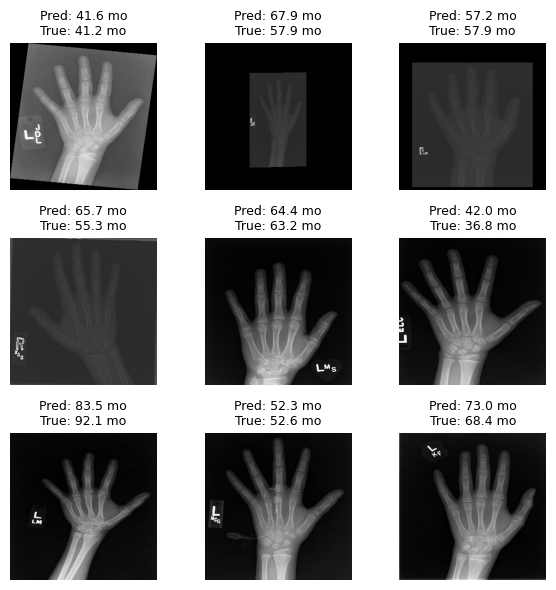

In [49]:
# Grab one batch from ds_val
(inputs, ages_true_norm) = next(iter(ds_val))
imgs = inputs['image_input']   # shape=(batch,224,224,3)
sexs = inputs['sex_input']     # shape=(batch,1)

# Predict on multi-input
y_norm_pred   = model.predict((imgs, sexs), verbose=0).flatten()
y_pred_months = y_norm_pred * 100.0
y_true_months = ages_true_norm.numpy().squeeze() * 100.0

# Plot up to 9 samples
n = min(imgs.shape[0], 9)
plt.figure(figsize=(6,6))
for i in range(n):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(imgs[i].numpy().astype('uint8'))  # or a simple clip if preprocessed
    ax.set_title(f"Pred: {y_pred_months[i]:.1f} mo\nTrue: {y_true_months[i]:.1f} mo",
                 fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()



79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


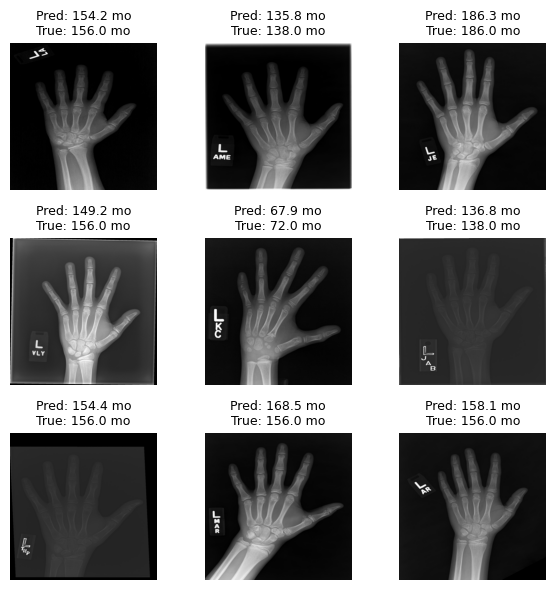

In [53]:
y_pred_norm = model.predict(ds_val).flatten()
# Extract the true normalized ages in the same order
y_true_norm = np.concatenate([y.numpy().flatten() for _, y in ds_val], axis=0)

# De-normalize back to months using your actual max_age
y_pred_months = y_pred_norm * max_age
y_true_months = y_true_norm * max_age

# Now pick 9 random indices
n = min(len(y_pred_months), 9)
idxs = np.random.choice(len(y_pred_months), size=n, replace=False)

plt.figure(figsize=(6,6))
for j, i in enumerate(idxs):
    ax = plt.subplot(3, 3, j+1)

    img = Image.open(str(val_df.iloc[i]['filepath'])).convert('RGB')
    img = img.resize(img_size)

    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {y_pred_months[i]:.1f} mo\nTrue: {y_true_months[i]:.1f} mo",
                 fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [54]:
# Re-build ds_val using parse_multi
ds_val = tf.data.Dataset.from_tensor_slices((
    val_df['filepath'].values,
    val_df['sex_norm'].values,
    val_df['boneage_norm'].values
))
ds_val = (
    ds_val
      .map(parse_multi, num_parallel_calls=tf.data.AUTOTUNE)
      .cache()
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

# predict
y_norm_pred = model.predict(ds_val, verbose=1).flatten()
y_pred      = y_norm_pred * 100.0
y_true      = val_df['boneage_norm'].values * 100.0

#  Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae   = mean_absolute_error(y_true, y_pred)
mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_true, y_pred)
acc6  = np.mean(np.abs(y_pred - y_true) <= 6.0)  * 100
acc12 = np.mean(np.abs(y_pred - y_true) <= 12.0) * 100

print(f"MAE:   {mae:.2f} months")
print(f"RMSE:  {rmse:.2f} months")
print(f"MSE:   {mse:.2f}")
print(f"R²:    {r2:.3f}")
print(f"% within ±6 mo:  {acc6:.1f}%")
print(f"% within ±12 mo: {acc12:.1f}%")


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step
MAE:   3.82 months
RMSE:  4.98 months
MSE:   24.83
R²:    0.926
% within ±6 mo:  79.9%
% within ±12 mo: 98.0%


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


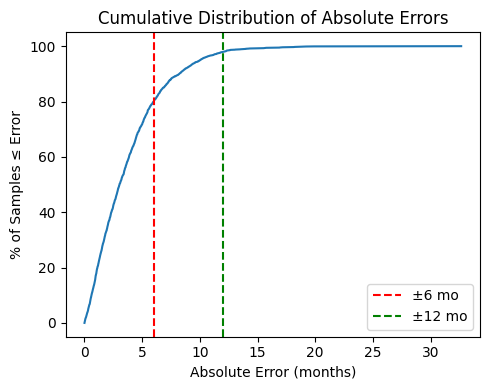

In [55]:
_norm_pred = model.predict(ds_val, verbose=1).flatten()
y_pred      = y_norm_pred * 100.0
y_true      = val_df['boneage_norm'].values * 100.0

# a fresh DataFrame of errors
df_errors = pd.DataFrame({
    'true_age':   y_true,
    'pred_age':   y_pred
})
df_errors['error']     = df_errors['pred_age'] - df_errors['true_age']
df_errors['abs_error'] = df_errors['error'].abs()

# the cumulative distribution of abs_error
errs    = np.sort(df_errors['abs_error'])
cum_perc = np.arange(1, len(errs)+1) / len(errs) * 100

plt.figure(figsize=(5,4))
plt.plot(errs, cum_perc)
plt.axvline(6, color='r', linestyle='--', label='±6 mo')
plt.axvline(12, color='g', linestyle='--', label='±12 mo')
plt.title('Cumulative Distribution of Absolute Errors')
plt.xlabel('Absolute Error (months)')
plt.ylabel('% of Samples ≤ Error')
plt.legend()
plt.tight_layout()
plt.show()


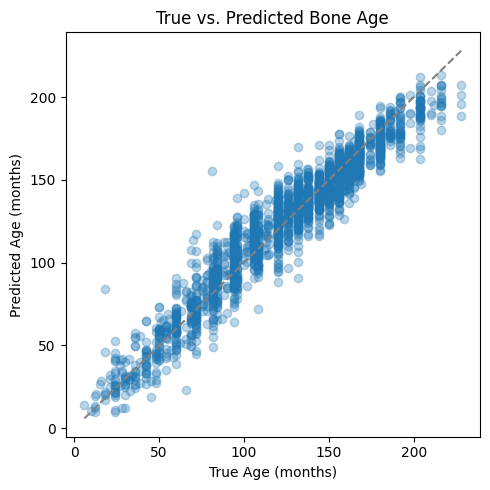

In [67]:
df_results = pd.DataFrame({
    'true_age': y_true_months,
    'pred_age':  y_pred_months
})
#  the scatter plot
plt.figure(figsize=(5,5))
plt.scatter(df_results['true_age'], df_results['pred_age'], alpha=0.3)

mn = min(df_results['true_age'].min(), df_results['pred_age'].min())
mx = max(df_results['true_age'].max(), df_results['pred_age'].max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='gray')

plt.title('True vs. Predicted Bone Age')
plt.xlabel('True Age (months)')
plt.ylabel('Predicted Age (months)')
plt.tight_layout()
plt.show()



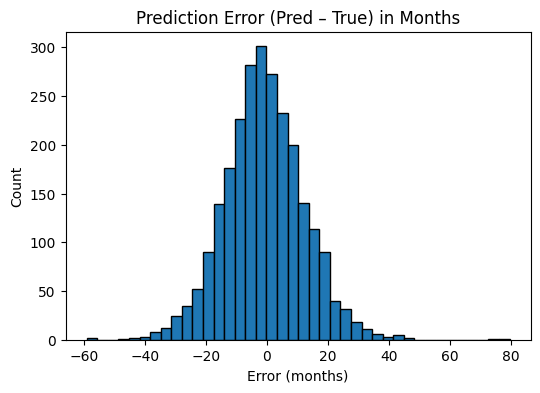

In [58]:
#  Plot histogram of errors
plt.figure(figsize=(6,4))
plt.hist(errors, bins=40, edgecolor='black')
plt.title('Prediction Error (Pred – True) in Months')
plt.xlabel('Error (months)')
plt.ylabel('Count')
plt.show()

In [59]:
# 1) Predict on the validation set again
y_norm_pred = model.predict(ds_val, verbose=1).flatten()
y_pred      = y_norm_pred * 100.0
y_true      = val_df['boneage_norm'].values * 100.0
sex_true    = val_df['sex_norm'].values.astype(int)

# 2) Rebuild the results DataFrame
results_df = pd.DataFrame({
    'true_age':  y_true,
    'pred_age':  y_pred,
    'sex':       sex_true
})
results_df['error']     = results_df['pred_age'] - results_df['true_age']
results_df['abs_error'] = results_df['error'].abs()

# 3) Create age bins if you haven’t already
bin_edges  = [0, 24, 72, np.inf]
bin_labels = ['Infant <2yr','Child 2–6yr','Adolescent >6yr']
results_df['age_bin'] = pd.cut(results_df['true_age'], bins=bin_edges, labels=bin_labels)

# 4) Define the subgroup_metrics function
def subgroup_metrics(df, group_col):
    records = []
    for name, sub in df.groupby(group_col):
        y_t = sub['true_age']
        y_p = sub['pred_age']
        mae  = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        acc6  = (np.abs(y_p - y_t) <= 6).mean()  * 100
        acc12 = (np.abs(y_p - y_t) <= 12).mean() * 100
        records.append({
            group_col: name,
            'count':   len(sub),
            'MAE':     mae,
            'RMSE':    rmse,
            '%≤6mo':   acc6,
            '%≤12mo':  acc12
        })
    return pd.DataFrame.from_records(records)

# 5) Run metrics by age bin and by gender
age_metrics    = subgroup_metrics(results_df, 'age_bin')
gender_metrics = subgroup_metrics(results_df.assign(sex_label=results_df['sex'].map({0:'F',1:'M'})),
                                  'sex_label')

print("Metrics by Age Bin:\n", age_metrics)
print("\nMetrics by Gender:\n", gender_metrics)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Metrics by Age Bin:
            age_bin  count       MAE      RMSE      %≤6mo     %≤12mo
0      Infant <2yr    161  3.650754  5.021053  82.608696  98.136646
1      Child 2–6yr   1921  3.822632  4.989334  80.062467  98.073920
2  Adolescent >6yr    441  3.856312  4.941670  78.458050  97.505669

Metrics by Gender:
   sex_label  count       MAE      RMSE      %≤6mo     %≤12mo
0         F   1156  3.972246  5.124493  77.595156  97.750865
1         M   1367  3.686734  4.860264  81.931236  98.171178


<ipython-input-59-71596843636b>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, sub in df.groupby(group_col):


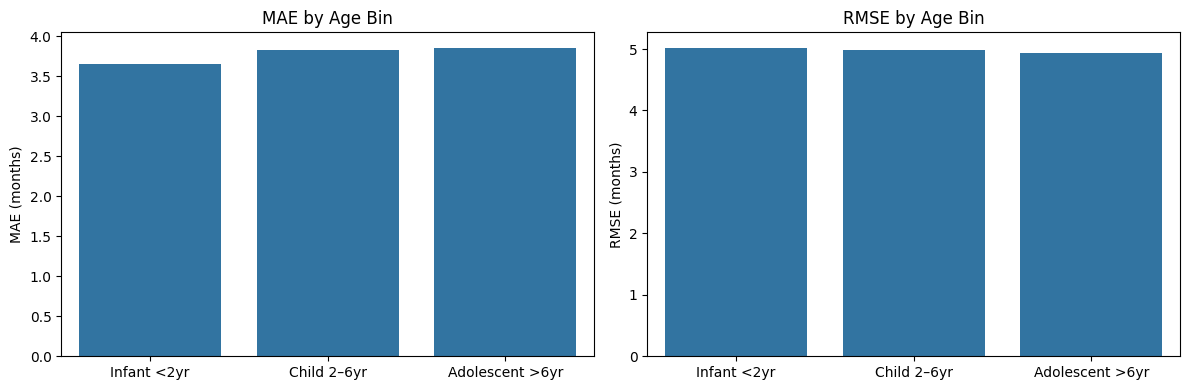

In [60]:
# Map numeric sex → labels
results_df['sex_label'] = results_df['sex'].map({0:'F', 1:'M'})

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.barplot(data=age_metrics, x='age_bin', y='MAE', ax=axes[0])
axes[0].set_title('MAE by Age Bin'); axes[0].set_ylabel('MAE (months)'); axes[0].set_xlabel('')
sns.barplot(data=age_metrics, x='age_bin', y='RMSE', ax=axes[1])
axes[1].set_title('RMSE by Age Bin'); axes[1].set_ylabel('RMSE (months)'); axes[1].set_xlabel('')
plt.tight_layout()
plt.show()



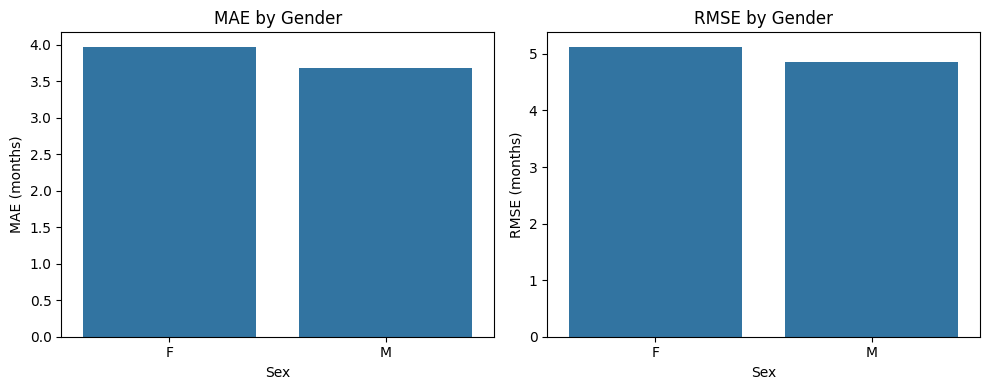

In [61]:
#4) Bar charts of MAE and RMSE by gender
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(data=gender_metrics, x='sex_label', y='MAE', ax=axes[0])
axes[0].set_title('MAE by Gender'); axes[0].set_ylabel('MAE (months)'); axes[0].set_xlabel('Sex')
sns.barplot(data=gender_metrics, x='sex_label', y='RMSE', ax=axes[1])
axes[1].set_title('RMSE by Gender'); axes[1].set_ylabel('RMSE (months)'); axes[1].set_xlabel('Sex')
plt.tight_layout()
plt.show()




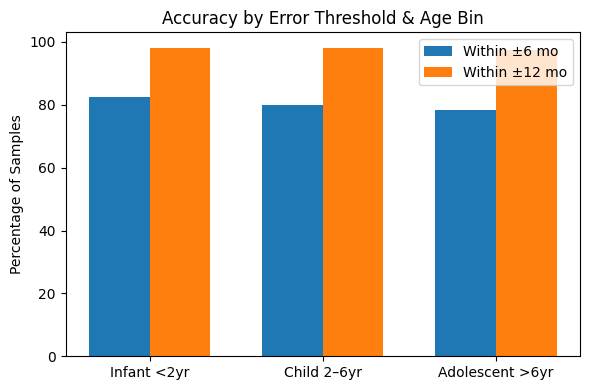

In [62]:
# 2) Bar chart of accuracy within ±6 mo and ±12 mo by age bin
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(age_metrics))
width = 0.35
ax.bar(x - width/2, age_metrics['%≤6mo'], width, label='Within ±6 mo')
ax.bar(x + width/2, age_metrics['%≤12mo'], width, label='Within ±12 mo')
ax.set_xticks(x)
ax.set_xticklabels(age_metrics['age_bin'])
ax.set_ylabel('Percentage of Samples')
ax.set_title('Accuracy by Error Threshold & Age Bin')
ax.legend()
plt.tight_layout()
plt.show()



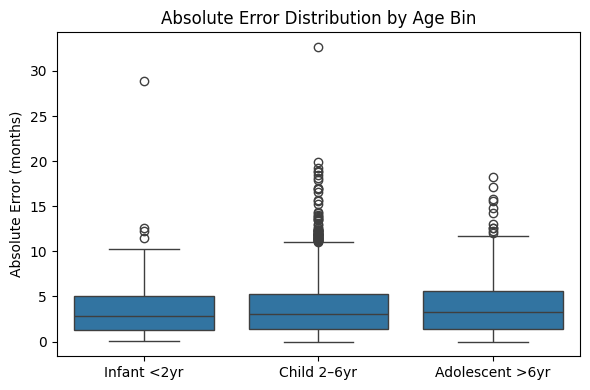

In [63]:
# 3) Boxplot of absolute error by age bin
plt.figure(figsize=(6,4))
sns.boxplot(data=results_df, x='age_bin', y='abs_error', order=age_metrics['age_bin'])
plt.title('Absolute Error Distribution by Age Bin')
plt.ylabel('Absolute Error (months)')
plt.xlabel('')
plt.tight_layout()
plt.show()


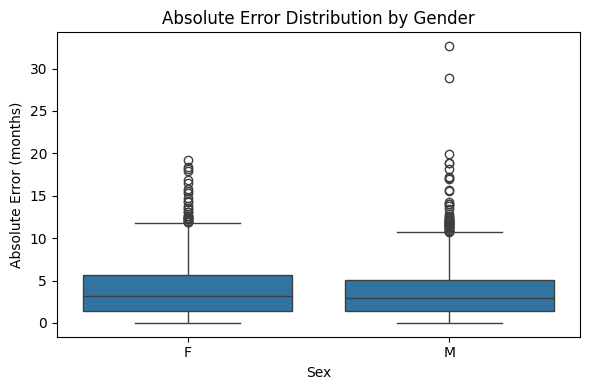

In [64]:
# 5) Boxplot of absolute error by gender
plt.figure(figsize=(6,4))
sns.boxplot(data=results_df, x='sex_label', y='abs_error')
plt.title('Absolute Error Distribution by Gender')
plt.ylabel('Absolute Error (months)')
plt.xlabel('Sex')
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Scatter of error vs. true_age colored by age_bin')

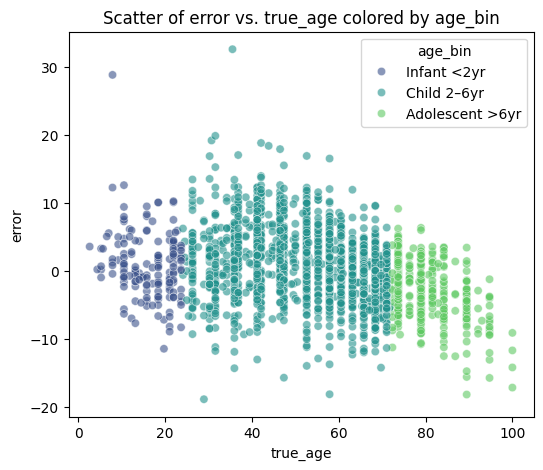

In [65]:
# 6) Scatter of error vs. true_age colored by age_bin
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=results_df,
    x='true_age', y='error',
    hue='age_bin', alpha=0.6,
    palette='viridis'
)
plt.title('Scatter of error vs. true_age colored by age_bin')


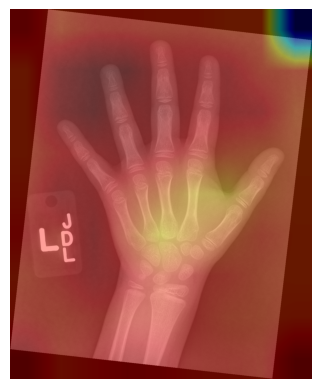

In [85]:
gap_layer = model.get_layer('global_average_pooling2d_2')
last_conv_tensor = gap_layer.input

# Build the small grad‐model
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_tensor, model.output]
)

#  Heatmap generator
def make_gradcam_heatmap(img_np, sex_val, grad_model):
    img_t = tf.convert_to_tensor(img_np, dtype=tf.float32)[None, ...]
    sex_t = tf.convert_to_tensor([[sex_val]], dtype=tf.float32)
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model([img_t, sex_t])
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv = conv_outputs[0]
    heatmap = tf.reduce_sum(conv * pooled[None,None,:], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay & display
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    heat = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    jet  = cv2.applyColorMap((heat*255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(jet, alpha, img, 1-alpha, 0)
    plt.imshow(overlay); plt.axis('off'); plt.show()

# Example on a validation case
i = 0
row     = val_df.iloc[i]
img_path = row.filepath
sex_val  = row.sex_norm

# oad at your model's img_size,
orig = load_img(img_path, target_size=img_size)
arr  = img_to_array(orig).astype('float32')
pre  = effnet_preprocess(arr)

# Compute & show
heatmap = make_gradcam_heatmap(pre, sex_val, grad_model)
display_gradcam(img_path, heatmap)